In [3]:
from typing import List, TypedDict
import time
import os

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import START, StateGraph, END

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\004NQ8744\OneDrive\Roadwork\langChain\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
groq_api_key = os.getenv("GROQ_API_KEY")
# llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.1-8b-instant")

In [7]:
docs = (
    PyPDFLoader("./documents/book1.pdf").load() +
    PyPDFLoader("./documents/book2.pdf").load()
)


In [8]:
len(docs)

1559

In [9]:
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)

Clean text to avoid UnicodeEncodeError (surrogates from PDF extraction)

In [10]:
for chunk in chunks:
    chunk.page_content = chunk.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

In [11]:
len(chunks)

5033

In [12]:
vector_store = FAISS.from_documents(chunks, embeddings)

In [13]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={'k':4})

In [14]:
class State(TypedDict):
    question: str
    docs: List[Document]
    answer: str

In [15]:
def retrieve(state):
    q = state["question"]
    return {"docs": retriever.invoke(q)}

In [16]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Answer only from the context. If not in context, say you don't know."),
        ("human", "Question: {question}\n\nContext:\n{context}"),
    ]
)

In [23]:
def generate(state):
    context = "\n\n".join(doc.page_content for doc in state["docs"])
    output = (prompt | llm).invoke({"question": state["question"], "context": context})
    return {"answer": output.content}

In [24]:
g = StateGraph(State)
g.add_node("retrieve", retrieve)
g.add_node("generate", generate)
g.add_edge(START, "retrieve")
g.add_edge("retrieve", "generate")
g.add_edge("generate", END)

app = g.compile()

In [19]:
app

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden']}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<question,docs,answer>(recurse=True, writes=[ChannelWriteEntry(channel='question', value=<object object at 0x000001E3372FAEC0>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='docs', value=<object object at 0x000001E3372FAEC0>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='answer', value=<object object at 0x000001E3372FAEC0>, skip_none=False, mapper=_get_state_key(recurse=False))]), ChannelWrite<start:retrieve>(recurse=True, writes=[ChannelWriteEntry(channel='start:retrieve', value='__start__', skip_none=False, mapper=None)])]), 'retrieve': PregelNode(config={'tags': []}, channels={'question': 'question', 'docs': 'docs', 'answer': 'answer'}, triggers=['start:retrieve'], mapper=functools.partial(<function _coerce_state at 0x000001E338953240>, <class '__main__.S

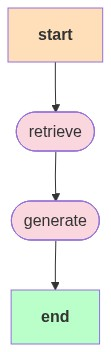

In [28]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [26]:
res = app.invoke({"question": "WHat is a transformer in deep learning.", "docs": [], "answer": ""})
print(res["answer"])

I don't know


In [27]:
res = app.invoke({"question": "What is deep learning.", "docs": [], "answer": ""})
print(res["answer"])

Deep learning is a type of artificial neural network that represents functions of increasing complexity by adding more layers and more units within a layer. It is a powerful framework for supervised learning and has a long history, dating back to the 1940s, although it has undergone several name changes and periods of increased and decreased popularity over the years.


Retrieval Refinement

In [29]:
import re
from pydantic import BaseModel

In [30]:
class State(TypedDict):
    question: str
    docs: List[Document]

    strips: List[str]
    kept_strips: List[str]
    refined_context: str

    answer: str

In [31]:
def retrieve(state):
    q = state["question"]
    return {"docs": retriever.invoke(q)}

Sentence level decomposer

In [32]:
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip())>20]

In [36]:
print(res["answer"])

Deep learning is a type of artificial neural network that represents functions of increasing complexity by adding more layers and more units within a layer. It is a powerful framework for supervised learning and has a long history, dating back to the 1940s, although it has undergone several name changes and periods of increased and decreased popularity over the years.


In [33]:
decompose_to_sentences(res["answer"])

['Deep learning is a type of artificial neural network that represents functions of increasing complexity by adding more layers and more units within a layer.',
 'It is a powerful framework for supervised learning and has a long history, dating back to the 1940s, although it has undergone several name changes and periods of increased and decreased popularity over the years.']

In [34]:
len(decompose_to_sentences(res["answer"]))

2

Filter (LLM Judge)

In [37]:
class KeepOrDrop(BaseModel):
    keep: bool

In [38]:
filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict relevance filter.\n"
            "Return keep=true only if the sentence directly helps answer the question.\n"
            "Use ONLY the sentence. Output JSON only.",
        ),
        ("human", "Question: {question}\n\nSentence:\n{sentence}"),
    ]
)

In [39]:
filter_chain = filter_prompt | llm.with_structured_output(KeepOrDrop)

Refining (Decompose=> Filter => Recompose)

In [47]:
def refine(state):
    q = state["question"]
    context = "\n\n".join(d.page_content for d in state["docs"]).strip()
    strips = decompose_to_sentences(context)
    kept: List[str] = []
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s})["keep"]:
            kept.append(s)
    refined_context = "/n".join(kept).strip()
    return {
        "strips": strips,
        "kept": kept,
        "refined_context": refined_context
    }

In [48]:
answer_prompt = ChatPromptTemplate.from_messages([
    (
            "system",
            "You are a helpful ML tutor. Answer ONLY using the provided refined bullets.\n"
            "If the bullets are empty or insufficient, say: 'I don't know based on the provided docs.'",
        ),
        ("human", "Question: {question}\n\nRefined context:\n{refined_context}"),
])

In [49]:
def generate(state):
    output = (answer_prompt | llm).invoke({"question": state["question"], "refined_context": state["refined_context"]})
    return {"answer": output.content}

In [50]:
g = StateGraph(State)
g.add_node("retrieve", retrieve)
g.add_node("refine", refine)
g.add_node("generate", generate)

g.add_edge(START, "retrieve")
g.add_edge("retrieve", "refine")
g.add_edge("refine", "generate")
g.add_edge("generate", END)

app = g.compile()
app

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden']}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<question,docs,strips,kept_strips,refined_context,answer>(recurse=True, writes=[ChannelWriteEntry(channel='question', value=<object object at 0x000001E3372FAEC0>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='docs', value=<object object at 0x000001E3372FAEC0>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='strips', value=<object object at 0x000001E3372FAEC0>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='kept_strips', value=<object object at 0x000001E3372FAEC0>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='refined_context', value=<object object at 0x000001E3372FAEC0>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='answer', value=<object object at 0x0

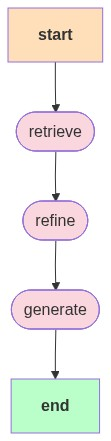

In [51]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [52]:
res = app.invoke({
    "question": "Explain the bias–variance tradeoff",
    "docs": [],
    "strips": [],
    "kept_strips": [],
    "refined_context": "",
    "answer": ""
})
print(res["answer"])

* The bias–variance tradeoff is the idea that there is a balance between model bias and variance.
* Model bias measures how far off a model's expected output is from the true output.
* Model variance measures how much the model's output varies across different training sets.
* Increasing model complexity (e.g., decreasing the regularization coefficient λ) reduces bias but increases variance.
* Decreasing model complexity (e.g., increasing the regularization coefficient λ) reduces variance but increases bias.
* The goal is to find a balance between bias and variance to minimize the expected loss.


In [53]:
print(res['docs'][0].page_content)
print('*'*100)
print(res['docs'][1].page_content)
print('*'*100)
print(res['docs'][2].page_content)
print('*'*100)
print(res['docs'][3].page_content)

3.2. The Bias-Variance Decomposition 151
Figure 3.6 Plot of squared bias and variance,
together with their sum, correspond-
ing to the results shown in Fig-
ure 3.5. Also shown is the average
test set error for a test data set size
of 1000 points. The minimum value
of (bias)2 + variance occurs around
ln λ = −0.31, which is close to the
value that gives the minimum error
on the test data.
lnλ
−3 −2 −1 0 1 2
0
0.03
0.06
0.09
0.12
0.15
(bias)2
variance
(bias)2 + variance
test error
ﬁt a model with 24 Gaussian basis functions by minimizing the regularized error
function (3.27) to give a prediction function y(l)(x) as shown in Figure 3.5. The
top row corresponds to a large value of the regularization coefﬁcientλ that gives low
variance (because the red curves in the left plot look similar) but high bias (because
****************************************************************************************************
with respect to multiple data sets.
We can also examine the bias-variance trade-

In [54]:
res["refined_context"]

'The top row corresponds to a large value of the regularization coefﬁcientλ that gives low variance (because the red curves in the left plot look similar) but high bias (because with respect to multiple data sets./nWe see that small values of λ allow the model to become ﬁnely tuned to the noise on each individual and the bias and variance terms now refer to integrated quantities./nOur goal is to minimize the expected loss, which we have decomposed into the sum of a (squared) bias, a variance, and a constant noise term.'